In [1]:
#importing packages
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Activation,LSTM,Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq


In [4]:
#Loading the data
path = '1661-0.txt'
text = open(path,encoding="utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [5]:
# Preprocessing data
character = sorted(list(set(text)))
char_indices = dict((c,i) for i,c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
print(f'unique chars: {len(character)}')

unique chars: 73


In [7]:
## chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0,len(text) - seq_len, step):
  sentences.append(text[i: i+seq_len])
  next_chars.append(text[i+seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [8]:
# generating our features and labels
# one hot encoding
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype = np.bool)
for i,sentence in enumerate(sentences):
  for t,char in enumerate(sentence):
    X[i,t,char_indices[char]] =1
    y[i,char_indices[next_chars[i]]] =1

sentences[124]
next_chars[100]

<ipython-input-8-7d7917732f60>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
<ipython-input-8-7d7917732f60>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(character)), dtype = np.bool)


'e'

In [9]:
## one hot encoded data
X[0][0]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [10]:
## one hot encoded data
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [11]:
#creating the model
model = Sequential()
model.add(LSTM(128,input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112841 (440.79 KB)
Trainable params: 112841 (440.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


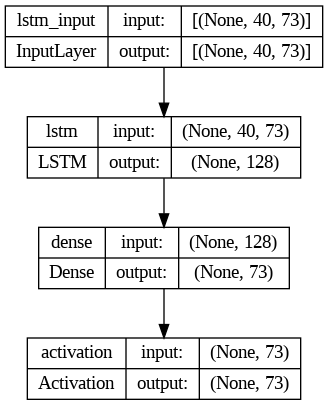

In [12]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [14]:
# Training the model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01,
                    batch_size=128,
                    epochs=30,
                    shuffle=True).history

Epoch 1/30
1501/1501 [==============================] - 156s 103ms/step - loss: 1.8932 - accuracy: 0.4386 - val_loss: 2.1836 - val_accuracy: 0.3933
Epoch 2/30
1501/1501 [==============================] - 154s 102ms/step - loss: 1.6239 - accuracy: 0.5126 - val_loss: 2.0524 - val_accuracy: 0.4304
Epoch 3/30
1501/1501 [==============================] - 153s 102ms/step - loss: 1.5253 - accuracy: 0.5394 - val_loss: 1.9709 - val_accuracy: 0.4505
Epoch 4/30
1501/1501 [==============================] - 154s 103ms/step - loss: 1.4710 - accuracy: 0.5549 - val_loss: 1.9154 - val_accuracy: 0.4572
Epoch 5/30
1501/1501 [==============================] - 153s 102ms/step - loss: 1.4328 - accuracy: 0.5639 - val_loss: 1.8903 - val_accuracy: 0.4840
Epoch 6/30
1501/1501 [==============================] - 154s 102ms/step - loss: 1.4059 - accuracy: 0.5707 - val_loss: 1.8835 - val_accuracy: 0.5010
Epoch 7/30
1501/1501 [==============================] - 152s 101ms/step - loss: 1.3846 - accuracy: 0.5761 - val_

In [15]:
# saving our model
model.save('wordpredict.h5')
pickle.dump(history, open("history.p", "wb"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
## loading the model
model = load_model('wordpredict.h5')
history = pickle.load(open("history.p", "rb"))

In [17]:
#Model Evaluation
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 118s 19ms/step - loss: 1.2131 - accuracy: 0.6218
Test Loss 1.2130770683288574
Test Accuracy 0.6217633485794067


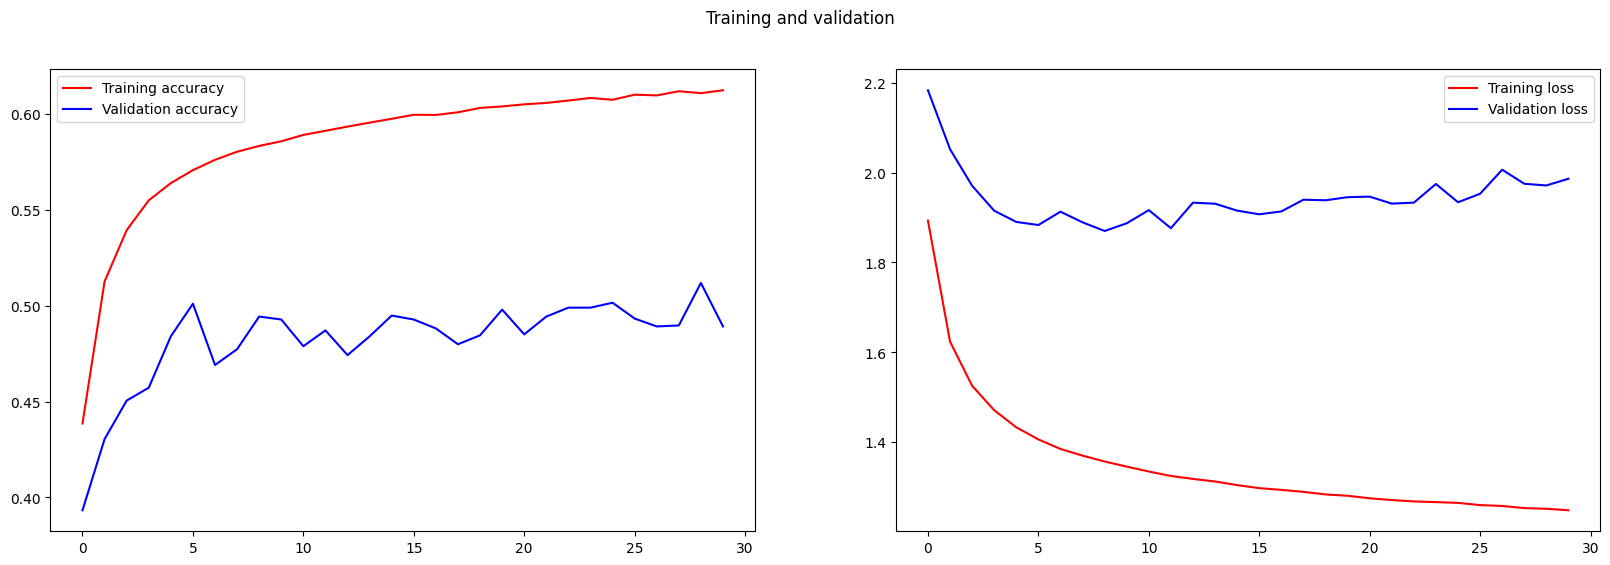

In [19]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


In [20]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.

    return x

prepare_input("This is an example of input of our model".lower())


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)


In [22]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [23]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [24]:
## PREDICTIONS
quotes = [
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "Machine learning  is the study of computer algorithms that improve automatically through experience and by the use of data.",
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work."

]

In [25]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
['ed ', ' to ', 'ing ', 't, ', 's ']

machine learning  is the study of comput
['e ', 'ter ', 'ion ', ' of ', 's ']

it is not a lack of love, but a lack of 
['the ', 'his ', 'my ', 'a ', 'which ']

recurrent neural network (rnn) is a type
['wrice ', 'rving ', 'ar ', 'et ', 'mite ']

thanks for spending your precious time t
['hat ', 'o ', 'err ', 'alked ', 'ime ']

